In [55]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_pipeline.fetcher.yfinance_fetcher import fetch_ohlcv
from models.monte_carlo import MonteCarloSimulator, plot_simulations, plot_final_distribution

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [56]:
ticker = 'AAPL'
df = fetch_ohlcv(ticker,start='2020-01-01')
df.tail()

2025-10-06 23:19:19,482  - INFO - Fetching OHLCV data from AAPL from 2020-01-01 to  2025-10-06
2025-10-06 23:19:19,510  - INFO - Downloaded 1447 rows for ticker AAPL


,date,open,high,low,close,adj_close,volume,dividends,splits,ticker
1442,2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,254.429993,40127700,0.0,0.0,AAPL
1443,2025-09-30 00:00:00-04:00,254.860001,255.919998,253.110001,254.630005,254.630005,37704300,0.0,0.0,AAPL
1444,2025-10-01 00:00:00-04:00,255.039993,258.790009,254.929993,255.449997,255.449997,48713900,0.0,0.0,AAPL
1445,2025-10-02 00:00:00-04:00,256.579987,258.179993,254.149994,257.130005,257.130005,42630200,0.0,0.0,AAPL
1446,2025-10-03 00:00:00-04:00,254.669998,259.239990,253.949997,258.019989,258.019989,49107000,0.0,0.0,AAPL


In [57]:
simulator = MonteCarloSimulator(seed=42)
mu,sigma = simulator.estimate_parameters(df['adj_close'])

print(f'''Drift : {mu: .2f} annually''')
print(f'''Volatility : {sigma: .2f} annually''')
print(f''' last price: {simulator.S0: .2f} annually''')

2025-10-06 23:19:19,565  - INFO - Estimated params: mu = 0.01393047579555002, sigma = 0.32199871730816104
2025-10-06 23:19:19,566  - INFO - Starting price:  258.02


Drift :  0.01 annually
Volatility :  0.32 annually
 last price:  258.02 annually


In [58]:
T_days = 30
n_simulations = 10000

#starting
price_paths = simulator.simulate(
    S0=simulator.S0,
    mu = mu,
    sigma = sigma,
    T=T_days,
    n_simulations = n_simulations,
)
price_paths.shape

2025-10-06 23:19:19,683  - INFO - Starting 10000 simulations on 30 days
2025-10-06 23:19:19,693  - INFO - Simulation finishe. Shape: (10000, 31)


(10000, 31)

In [59]:
stats = simulator.get_statistics(price_paths)
print(f'Median: {stats['median'][-1]: .2f}')
print(f'Mean: {stats['mean'][-1]: .2f}')
print(f'5th percentile: {stats['percentile_5'][-1]: .2f}')
print(f'95th percentile: {stats['percentile_95'][-1]: .2f}')

Median:  257.45
Mean:  258.50
5th percentile:  213.13
95th percentile:  308.23


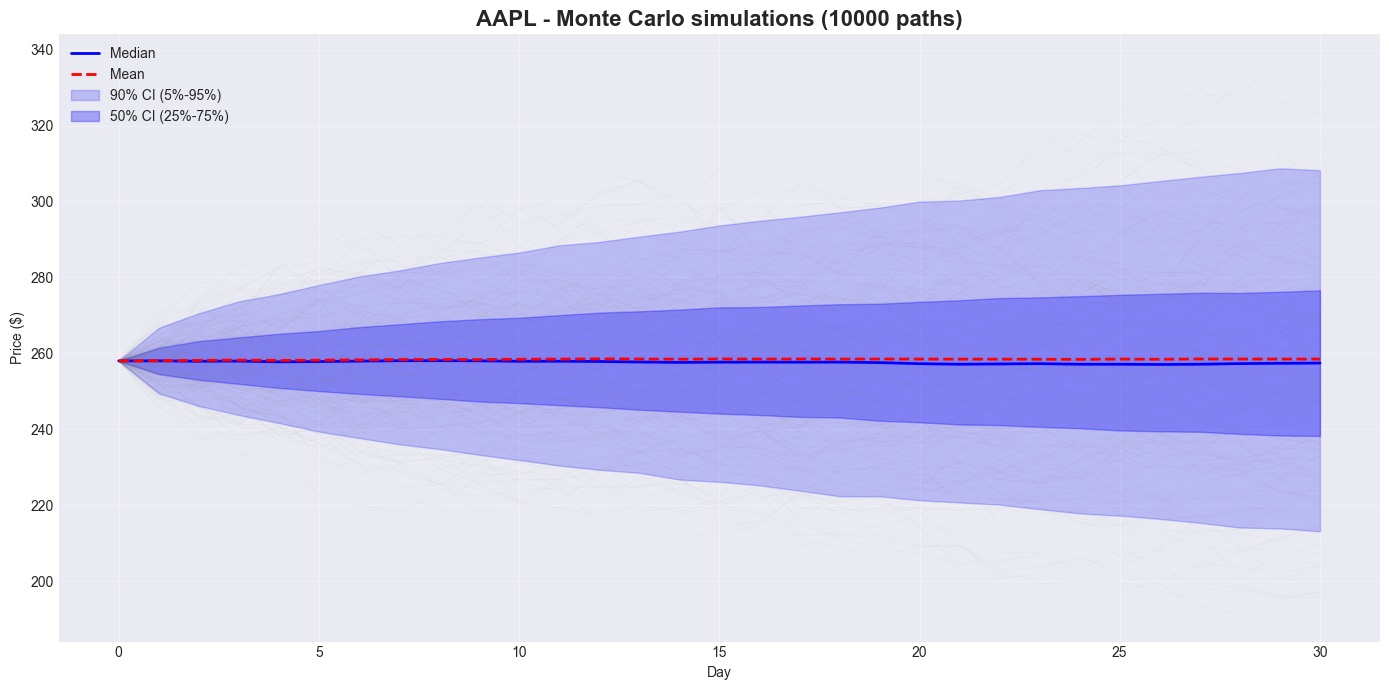

In [60]:
plot_simulations(price_paths,stats,ticker,n_paths_to_plot=200)

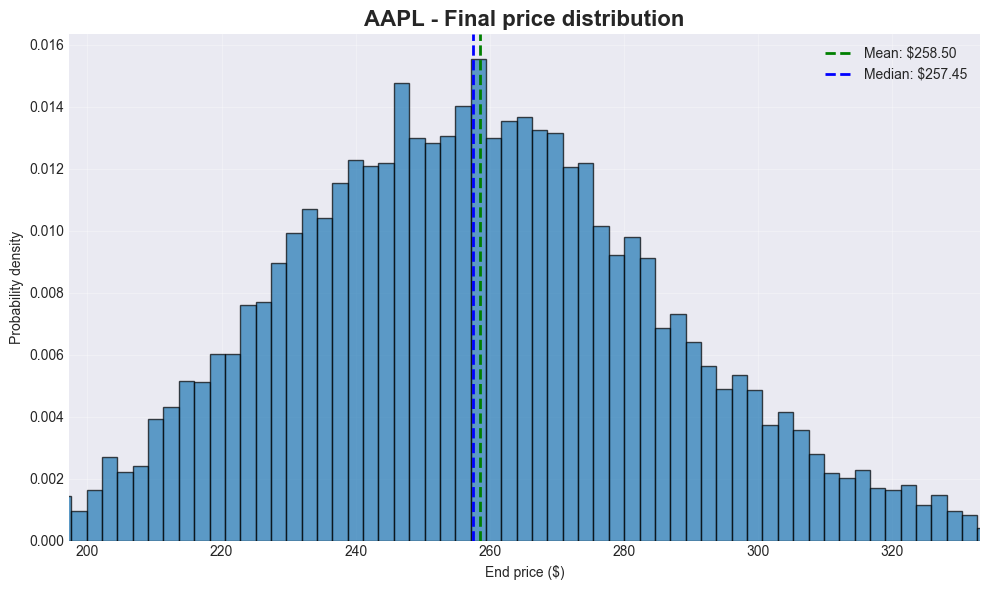

In [61]:
plot_final_distribution(price_paths,ticker)

In [62]:
risk_metrics = simulator.calculate_risk_metrics(price_paths,confidence_level=0.95)

print(f'Expected return: {risk_metrics['expected_return']: .2%}')
print(f'Best possible return: {risk_metrics["best_case"]: .2%}')
print(f'Worst possible return: {risk_metrics["worst_case"]: .2%}')

print(f'VaR(95%): {risk_metrics['var_95']: .2%}')
print(f'Expected Shortfall: {risk_metrics["expected_shortfall"]: .2%}')
print(f'Standard Deviation: {risk_metrics["std_return"]: .2%}')

print(f'P(return): {risk_metrics["probability_profit"]: .2%}')

2025-10-06 23:19:20,432  - INFO - Risk metrics:(Var 95%: -17.40%)


Expected return:  0.19%
Best possible return:  56.45%
Worst possible return: -32.29%
VaR(95%): -17.40%
Expected Shortfall: -21.03%
Standard Deviation:  11.26%
P(return):  49.06%


## Return Metrics
- **Expected return:** average expected return from the simulations
- **Best case scenario:** the most optimistic outcome observed in the simulations
- **Worst case scenario:** the most pessimistic outcome observed in the simulations

---

## Risk Metrics
- **Value at Risk (95%):** maximum expected loss at the 5% worst outcomes
- **Expected Shortfall (CVaR):** average loss given that the result falls within the worst 5%
- **Standard Deviation of returns:** measure of volatility in the simulated outcomes

---

## Probabilities
- **Probability of profit:** the proportion of simulations that ended with a positive return

---

## Interpretation
- **VaR (95%)**: In 95% of cases, losses should not exceed this threshold.
- **Expected Shortfall (CVaR)**: If results fall within the worst 5% of scenarios, the average loss will be around this level.
- **Probability of profit**: Indicates how often the simulations produced a gain rather than a loss.



In [63]:
current_price = simulator.S0
targets = [
    current_price*0,95,
    current_price*1,
    current_price*1.05,
    current_price*1.1,
    current_price*1.15,
]
#probability of reaching the goal
probabilities = []
for target in targets:
    prob = simulator.probability_above_target(price_paths, target)
    probabilities.append(prob)
    change_pct = (target / current_price - 1)*100
    print(f'Price >= {target: .2f} ({change_pct:+.1f}%): {prob:.1%}')


2025-10-06 23:19:20,476  - INFO - P(price >= $ 0.00) = 1.00
2025-10-06 23:19:20,478  - INFO - P(price >= $ 95.00) = 1.00
2025-10-06 23:19:20,479  - INFO - P(price >= $ 258.02) = 0.49
2025-10-06 23:19:20,479  - INFO - P(price >= $ 270.92) = 0.32
2025-10-06 23:19:20,480  - INFO - P(price >= $ 283.82) = 0.18
2025-10-06 23:19:20,481  - INFO - P(price >= $ 296.72) = 0.10


Price >=  0.00 (-100.0%): 100.0%
Price >=  95.00 (-63.2%): 100.0%
Price >=  258.02 (+0.0%): 49.1%
Price >=  270.92 (+5.0%): 31.7%
Price >=  283.82 (+10.0%): 17.9%
Price >=  296.72 (+15.0%): 9.8%


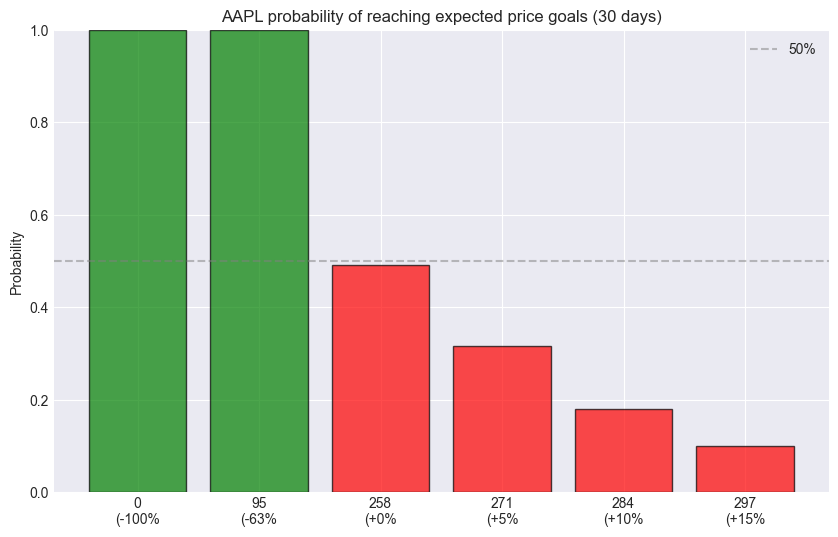

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

target_labels = [f'{t:.0f}\n({(t/current_price-1)*100:+.0f}%' for t in targets]
colors = ['red' if p<0.5 else 'green' for p in probabilities]
bars = ax.bar(range(len(targets)),probabilities,color=colors, alpha = 0.7, edgecolor='black')
ax.set_xticks(range(len(targets)))
ax.set_xticklabels(target_labels)
ax.set_ylabel('Probability')
ax.set_title(f'{ticker} probability of reaching expected price goals ({T_days} days)')
ax.axhline(y=0.5,color='gray',linestyle='--',alpha=0.5,label='50%')
ax.set_ylim(0,1)
ax.legend()

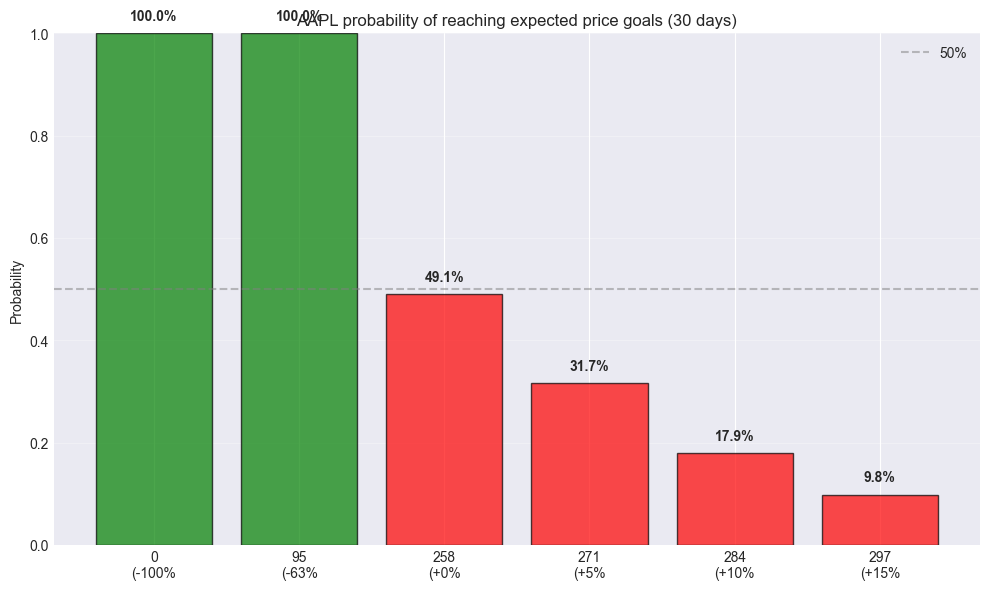

In [65]:
fig, ax = plt.subplots(figsize=(10,6))

target_labels = [f'{t:.0f}\n({(t/current_price-1)*100:+.0f}%' for t in targets]
colors = ['red' if p<0.5 else 'green' for p in probabilities]
bars = ax.bar(range(len(targets)),probabilities,color=colors, alpha = 0.7, edgecolor='black')
ax.set_xticks(range(len(targets)))
ax.set_xticklabels(target_labels)
ax.set_ylabel('Probability')
ax.set_title(f'{ticker} probability of reaching expected price goals ({T_days} days)')
ax.axhline(y=0.5,color='gray',linestyle='--',alpha=0.5,label='50%')
ax.set_ylim(0,1)
ax.legend()
for i, (bar,prob) in enumerate(zip(bars, probabilities)):
    height = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2., height + 0.02,
            f'{prob:.1%}',ha='center',va='bottom',fontweight='bold')

plt.grid(True,alpha=0.3,axis='y')
plt.tight_layout()
plt.show()

In [66]:
time_horizons = [7,30,90,252]
horizon_stats = {}

for T in time_horizons:
    paths = simulator.simulate(simulator.S0,mu,sigma,T,n_simulations=5000)
    stats_T = simulator.get_statistics(paths)
    risk_T = simulator.calculate_risk_metrics(paths)

    horizon_stats[T] = {
        'median': stats_T['median'][-1],
        'p5':stats_T['percentile_5'][-1],
        'p95':stats_T['percentile_95'][-1],
        'var':risk_T['var_95'],
        'prob_profit':risk_T['probability_profit'],
    }
    print(f"   {T:3d} days: median=${stats_T['median'][-1]:.2f}, VaR={risk_T['var_95']:.2%}")

2025-10-06 23:19:20,918  - INFO - Starting 5000 simulations on 7 days
2025-10-06 23:19:20,920  - INFO - Simulation finishe. Shape: (5000, 8)
2025-10-06 23:19:20,926  - INFO - Risk metrics:(Var 95%: -8.38%)
2025-10-06 23:19:20,927  - INFO - Starting 5000 simulations on 30 days
2025-10-06 23:19:20,933  - INFO - Simulation finishe. Shape: (5000, 31)
2025-10-06 23:19:20,948  - INFO - Risk metrics:(Var 95%: -17.23%)
2025-10-06 23:19:20,949  - INFO - Starting 5000 simulations on 90 days
2025-10-06 23:19:20,965  - INFO - Simulation finishe. Shape: (5000, 91)
2025-10-06 23:19:21,003  - INFO - Risk metrics:(Var 95%: -28.92%)
2025-10-06 23:19:21,004  - INFO - Starting 5000 simulations on 252 days
2025-10-06 23:19:21,043  - INFO - Simulation finishe. Shape: (5000, 253)


     7 days: median=$257.62, VaR=-8.38%
    30 days: median=$257.61, VaR=-17.23%
    90 days: median=$253.95, VaR=-28.92%


2025-10-06 23:19:21,146  - INFO - Risk metrics:(Var 95%: -44.22%)


   252 days: median=$247.55, VaR=-44.22%


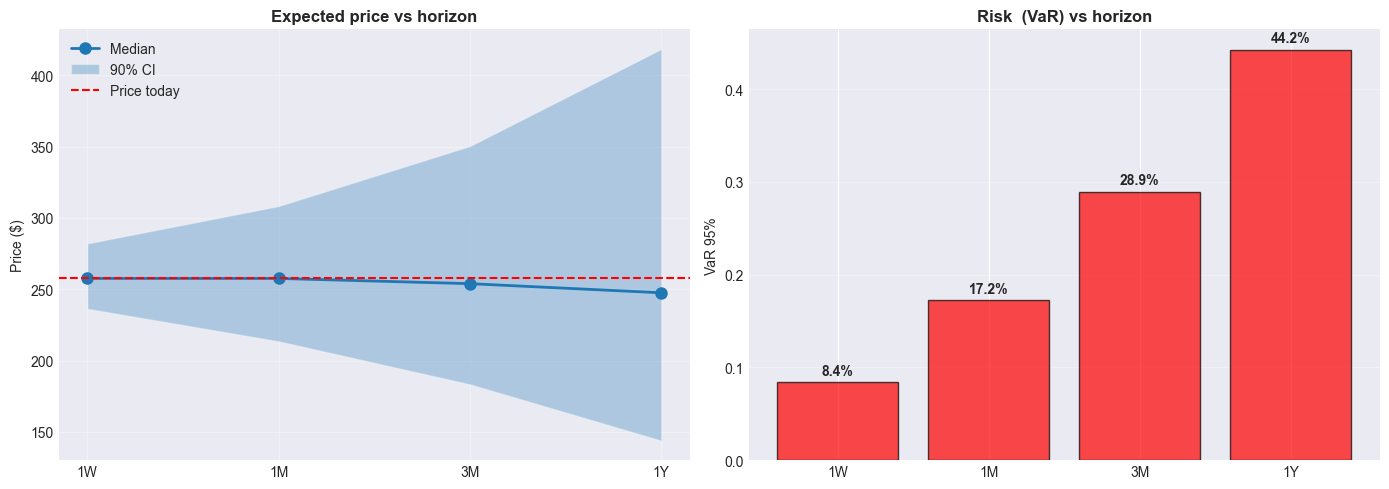

In [67]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
horizon_labels = ['1W','1M','3M','1Y']
medians = [horizon_stats[T]['median'] for T in time_horizons]
p5s = [horizon_stats[T]['p5'] for T in time_horizons]
p95s = [horizon_stats[T]['p95'] for T in time_horizons]
x_pos = np.arange(len(time_horizons))
axes[0].plot(x_pos,medians,marker='o',linewidth=2,markersize=8,label='Median')
axes[0].fill_between(x_pos,p5s,p95s,label='90% CI',alpha=0.3)
axes[0].axhline(y=simulator.S0,color='red',linestyle='--',label='Price today')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(horizon_labels)
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Expected price vs horizon',fontweight='bold')
axes[0].legend()
axes[0].grid(True,alpha=0.3)

vars_list = [horizon_stats[T]['var'] for T in time_horizons]
axes[1].bar(x_pos,[abs(v) for v in vars_list], alpha=0.7,color='red',edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(horizon_labels)
axes[1].set_ylabel('VaR 95%')
axes[1].set_title('Risk  (VaR) vs horizon',fontweight='bold')
axes[1].grid(True,alpha=0.3,axis='y')

for i,v in enumerate(vars_list):
    axes[1].text(i,abs(v)+0.005,f'{abs(v):.1%}',ha='center',va='bottom',fontweight='bold')

plt.tight_layout()
plt.show()



In [68]:
tickers_to_compare = ['AAPL','MSFT','TSLA','SPY']
comparison_results = {}

for tick in tickers_to_compare:
    df_temp = fetch_ohlcv(tick,start='2020-01-01')
    if df_temp.empty:
        continue
    sim_temp = MonteCarloSimulator(42)
    mu_temp, sigma_temp = sim_temp.estimate_parameters(df_temp['adj_close'])
    paths_temp = sim_temp.simulate(sim_temp.S0,mu_temp,sigma_temp,30,5000)
    risk_temp = sim_temp.calculate_risk_metrics(paths_temp)

    comparison_results[tick] = {
        'mu': mu_temp,
        'sigma': sigma_temp,
        'current_price': sim_temp.S0,
        'expected_return': risk_temp['expected_return'],
        'var_95': risk_temp['var_95'],
        'prob_profit': risk_temp['probability_profit']
    }
    print(f'{tick:6s}: mu={mu_temp:6.2%}, sigma={sigma_temp:6.2%}, '
      f'E[R]={risk_temp["expected_return"]:6.2%}, VaR={risk_temp["var_95"]:6.2%}')






2025-10-06 23:19:21,373  - INFO - Fetching OHLCV data from AAPL from 2020-01-01 to  2025-10-06
2025-10-06 23:19:21,395  - INFO - Downloaded 1447 rows for ticker AAPL
2025-10-06 23:19:21,396  - INFO - Estimated params: mu = 0.01393047579555002, sigma = 0.32199871730816104
2025-10-06 23:19:21,397  - INFO - Starting price:  258.02
2025-10-06 23:19:21,397  - INFO - Starting 5000 simulations on 30 days
2025-10-06 23:19:21,403  - INFO - Simulation finishe. Shape: (5000, 31)
2025-10-06 23:19:21,405  - INFO - Risk metrics:(Var 95%: -17.23%)
2025-10-06 23:19:21,405  - INFO - Fetching OHLCV data from MSFT from 2020-01-01 to  2025-10-06
2025-10-06 23:19:21,421  - INFO - Downloaded 1447 rows for ticker MSFT
2025-10-06 23:19:21,423  - INFO - Estimated params: mu = 0.013389563399404385, sigma = 0.2989348746822013
2025-10-06 23:19:21,423  - INFO - Starting price:  517.35
2025-10-06 23:19:21,423  - INFO - Starting 5000 simulations on 30 days
2025-10-06 23:19:21,430  - INFO - Simulation finishe. Shape:

AAPL  : mu= 1.39%, sigma=32.20%, E[R]= 0.29%, VaR=-17.23%
MSFT  : mu= 1.34%, sigma=29.89%, E[R]= 0.27%, VaR=-16.06%
TSLA  : mu= 2.97%, sigma=67.09%, E[R]= 0.64%, VaR=-33.49%
SPY   : mu= 0.89%, sigma=21.07%, E[R]= 0.18%, VaR=-11.52%


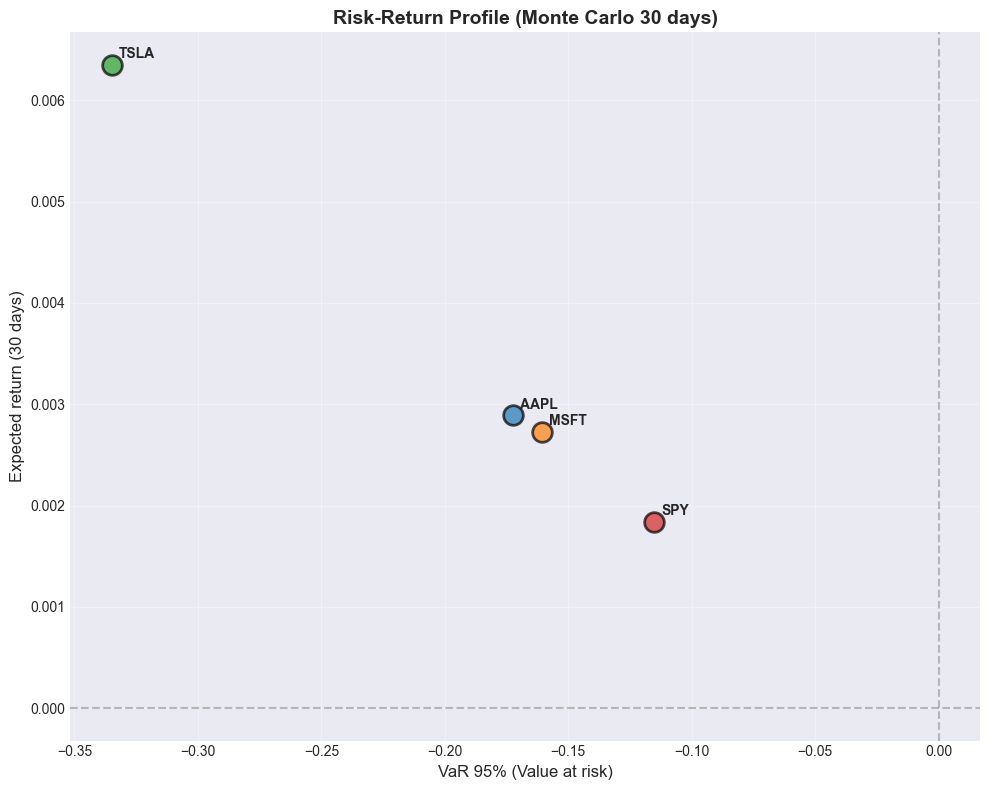

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
for tick, results in comparison_results.items():
    ax.scatter(results['var_95'],results['expected_return'],s=200,alpha=0.7,edgecolors='black',linewidth=2)
    ax.annotate(tick,(results['var_95'],results['expected_return']),xytext=(5,5),textcoords='offset points',fontweight='bold')

ax.axhline(y=0,color='gray',linestyle='--',alpha=0.5)
ax.axvline(x=0,color='gray',linestyle='--',alpha=0.5)
ax.set_xlabel('VaR 95% (Value at risk)',fontsize=12)
ax.set_ylabel('Expected return (30 days)', fontsize=12)
ax.set_title('Risk-Return Profile (Monte Carlo 30 days)',fontweight='bold', fontsize=14)
ax.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()




In [70]:
base_mu = mu
base_sigma = sigma
sigma_multipliers = [0.5,0.75,1.0,1.25,1.5]
sensitivity_results = {}

for mult in sigma_multipliers:
    test_sigma = base_sigma * mult
    paths_test = simulator.simulate(simulator.S0,base_mu,test_sigma,30,3000)
    stats_test = simulator.get_statistics(paths_test)
    risk_test = simulator.calculate_risk_metrics(paths_test)

    sensitivity_results[mult] = {
        'sigma': test_sigma,
        'median':stats_test['median'][-1],
        'var':risk_test['var_95'],
        'expected_return':risk_test['expected_return']
    }
    print(f' sigma x {mult:.2f} = {test_sigma:0.2%}',
          f'VaR = {risk_test['var_95']:.2%}, E[R] = {risk_test['expected_return']:.2%}')

2025-10-06 23:19:21,672  - INFO - Starting 3000 simulations on 30 days
2025-10-06 23:19:21,676  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-06 23:19:21,683  - INFO - Risk metrics:(Var 95%: -8.91%)
2025-10-06 23:19:21,685  - INFO - Starting 3000 simulations on 30 days
2025-10-06 23:19:21,688  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-06 23:19:21,695  - INFO - Risk metrics:(Var 95%: -13.23%)
2025-10-06 23:19:21,696  - INFO - Starting 3000 simulations on 30 days
2025-10-06 23:19:21,698  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-06 23:19:21,706  - INFO - Risk metrics:(Var 95%: -17.41%)
2025-10-06 23:19:21,706  - INFO - Starting 3000 simulations on 30 days
2025-10-06 23:19:21,710  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-06 23:19:21,720  - INFO - Risk metrics:(Var 95%: -21.45%)
2025-10-06 23:19:21,721  - INFO - Starting 3000 simulations on 30 days
2025-10-06 23:19:21,724  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-06 23:19:21,73

 sigma x 0.50 = 16.10% VaR = -8.91%, E[R] = 0.22%
 sigma x 0.75 = 24.15% VaR = -13.23%, E[R] = 0.26%
 sigma x 1.00 = 32.20% VaR = -17.41%, E[R] = 0.30%
 sigma x 1.25 = 40.25% VaR = -21.45%, E[R] = 0.34%
 sigma x 1.50 = 48.30% VaR = -25.35%, E[R] = 0.39%


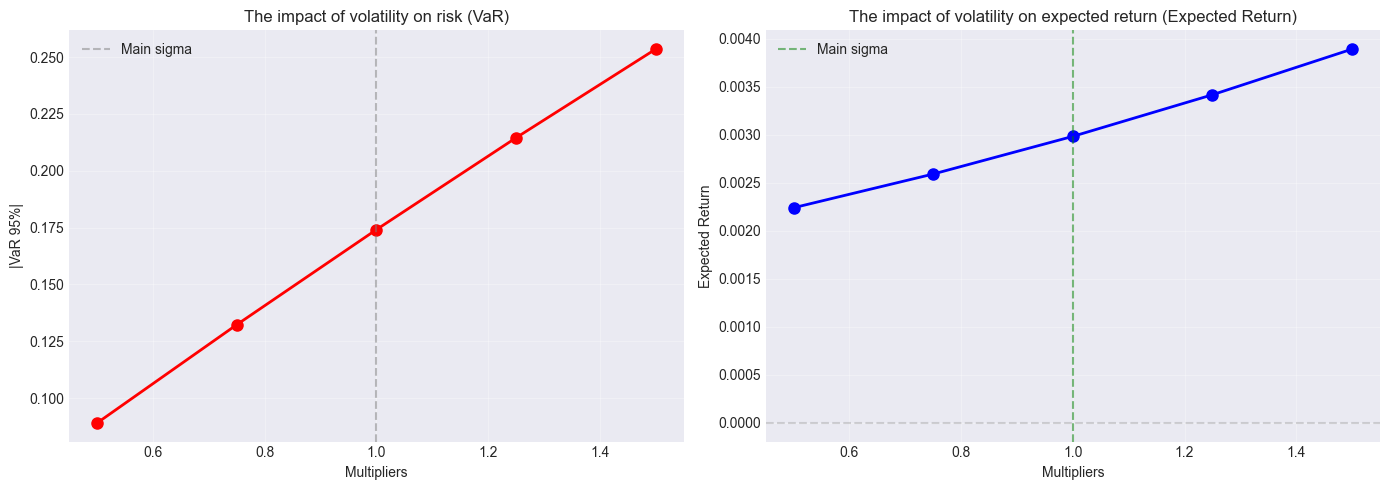

   Higher volatility (σ) → higher VaR (greater risk)
   But note: in GBM, higher σ → lower expected return!
   (because of the -0.5σ² term in the drift formula)


In [71]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

multipliers = list(sensitivity_results.keys())
vars_sens = [abs(sensitivity_results[m]['var']) for m in multipliers]
expected_returns = [sensitivity_results[m]['expected_return'] for m in multipliers]

axes[0].plot(multipliers,vars_sens,marker='o',linewidth=2,markersize=8,color='red')
axes[0].set_xlabel('Multipliers')
axes[0].set_ylabel('|VaR 95%|')
axes[0].set_title('The impact of volatility on risk (VaR)')
axes[0].grid(True,alpha=0.3)
axes[0].axvline(x=1.0,color='gray',linestyle='--',alpha=0.5,label='Main sigma')
axes[0].legend()

axes[1].plot(multipliers,expected_returns,marker='o',linewidth=2,markersize=8,color='blue')
axes[1].set_xlabel('Multipliers')
axes[1].set_ylabel('Expected Return')
axes[1].set_title('The impact of volatility on expected return (Expected Return)')
axes[1].grid(True,alpha=0.3)
axes[1].axvline(x=1.0,color='green',linestyle='--',alpha=0.5,label='Main sigma')
axes[1].axhline(y=0,color='gray',linestyle='--',alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("   Higher volatility (σ) → higher VaR (greater risk)")
print("   But note: in GBM, higher σ → lower expected return!")
print("   (because of the -0.5σ² term in the drift formula)")



2025-10-06 23:19:21,973  - INFO - Starting 10000 simulations on 30 days
2025-10-06 23:19:21,983  - INFO - Simulation finishe. Shape: (10000, 31)
2025-10-06 23:19:21,985  - INFO - Risk metrics:(Var 95%: -17.40%)



 I want to invest 10000$ in AAPL for 30 days
Actual price:  258.02
I'm buying 38.76 shares

 Result of simulation (30 days)
 Portfolio values (median): $9,977.94
 Expected return: $18.57
Scenerios
 Return: 4906 (49.06%)
 Loss: 5094 (50.94%)
   VaR (95%): $1,739.70 (-17.40%)
   Expected Shortfall: $2,103.31 (-21.03%)
   → In  5% scenerios I will loss avg  $2,103.31


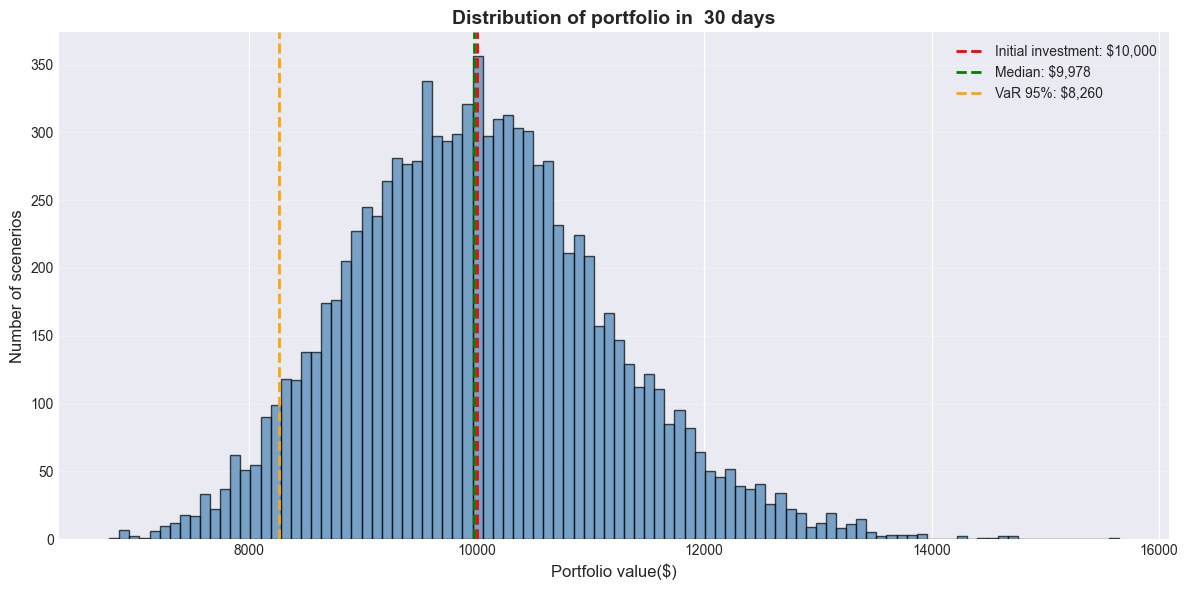

In [72]:
#Decision sample
decision_ticker = 'AAPL'
decision_horizon=30
investment = 10000

print(f'\n I want to invest {investment:.0f}$ in {decision_ticker} for {decision_horizon} days')
print(f'Actual price: {simulator.S0: .2f}')
n_shares = investment/simulator.S0
print(f"I'm buying {n_shares:.2f} shares")

decision_paths = simulator.simulate(simulator.S0,mu,sigma,decision_horizon,10000)
decision_risk = simulator.calculate_risk_metrics(decision_paths)

portfolio_values = decision_paths[:,-1]*n_shares
print(f"\n Result of simulation ({decision_horizon} days)")
print(f" Portfolio values (median): ${np.median(portfolio_values):,.2f}")
print(f" Expected return: ${portfolio_values.mean()-investment:,.2f}")

profit_scenerios = (portfolio_values > investment).sum()
loss_scenarios = (portfolio_values < investment).sum()

print(f"Scenerios")
print(f" Return: {profit_scenerios:.0f} ({profit_scenerios/len(portfolio_values):.2%})")
print(f" Loss: {loss_scenarios:.0f} ({loss_scenarios/len(portfolio_values):.2%})")

var_dollars = investment * abs(decision_risk['var_95'])
es_dollars = investment * abs(decision_risk['expected_shortfall'])

print(f"   VaR (95%): ${var_dollars:,.2f} ({decision_risk['var_95']:.2%})")
print(f"   Expected Shortfall: ${es_dollars:,.2f} ({decision_risk['expected_shortfall']:.2%})")
print(f"   → In  5% scenerios I will loss avg  ${es_dollars:,.2f}")

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(portfolio_values, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(investment, color='red', linestyle='--', linewidth=2,
           label=f'Initial investment: ${investment:,.0f}')
ax.axvline(np.median(portfolio_values), color='green', linestyle='--', linewidth=2,
           label=f'Median: ${np.median(portfolio_values):,.0f}')

# VaR threshold
var_threshold = investment * (1 + decision_risk['var_95'])
ax.axvline(var_threshold, color='orange', linestyle='--', linewidth=2,
           label=f'VaR 95%: ${var_threshold:,.0f}')

ax.set_xlabel('Portfolio value($)', fontsize=12)
ax.set_ylabel('Number of scenerios', fontsize=12)
ax.set_title(f'Distribution of portfolio in  {decision_horizon} days',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

bad numbers, stopped coding for a while
